What do you notice about the loaded trained model results versus the original (pre-exported) model results?


## Scikit-Learn Regression Practice

For the next few exercises, we're going to be working on a regression problem, in other words, using some data to predict a number.

Our dataset is a [table of car sales](https://docs.google.com/spreadsheets/d/1LPEIWJdSSJYrfn-P3UQDIXbEn5gg-o6I7ExLrWTTBWs/edit?usp=sharing), containing different car characteristics as well as a sale price.

We'll use Scikit-Learn's built-in regression machine learning models to try and learn the patterns in the car characteristics and their prices on a certain group of the dataset before trying to predict the sale price of a group of cars the model has never seen before.

To begin, we'll [import the data from GitHub](https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/car-sales-extended-missing-data.csv) into a pandas DataFrame, check out some details about it and try to build a model as soon as possible.

In [2]:
# Read in the car sales data
import pandas as pd
car_sales = pd.read_csv("https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/car-sales-extended-missing-data.csv")

# View the first 5 rows of the car sales data
###
car_sales.head()

,Make,Colour,Odometer (KM),Doors,Price
0,Honda,White,35431.0,4.0,15323.0
1,BMW,Blue,192714.0,5.0,19943.0
2,Honda,White,84714.0,4.0,28343.0
3,Toyota,White,154365.0,4.0,13434.0
4,Nissan,Blue,181577.0,3.0,14043.0


In [3]:
# Get information about the car sales DataFrame
###
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           951 non-null    object 
 1   Colour         950 non-null    object 
 2   Odometer (KM)  950 non-null    float64
 3   Doors          950 non-null    float64
 4   Price          950 non-null    float64
dtypes: float64(3), object(2)
memory usage: 39.2+ KB


Looking at the output of `info()`,
* How many rows are there total?
* What datatypes are in each column?
* How many missing values are there in each column?

In [4]:
# Find number of missing values in each column
###
car_sales.isna().sum()

Make             49
Colour           50
Odometer (KM)    50
Doors            50
Price            50
dtype: int64

In [5]:
# Find the datatypes of each column of car_sales
###
car_sales.dtypes

Make              object
Colour            object
Odometer (KM)    float64
Doors            float64
Price            float64
dtype: object

Knowing this information, what would happen if we tried to model our data as it is?

Let's see.

In [6]:
# EXAMPLE: This doesn't work because our car_sales data isn't all numerical
from sklearn.ensemble import RandomForestRegressor
car_sales_X, car_sales_y = car_sales.drop("Price", axis=1), car_sales.Price
rf_regressor = RandomForestRegressor().fit(car_sales_X, car_sales_y)

ValueError: could not convert string to float: 'Honda'

As we see, the cell above breaks because our data contains non-numerical values as well as missing data.

To take care of some of the missing data, we'll remove the rows which have no labels (all the rows with missing values in the `Price` column).

In [7]:
# Remove rows with no labels (NaN's in the Price column)
###
car_sales.dropna(subset=["Price"], inplace=True)

### Building a pipeline
Since our `car_sales` data has missing numerical values as well as the data isn't all numerical, we'll have to fix these things before we can fit a machine learning model on it.

There are ways we could do this with pandas but since we're practicing Scikit-Learn, we'll see how we might do it with the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class. 

Because we're modifying columns in our dataframe (filling missing values, converting non-numerical data to numbers) we'll need the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) and [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) classes as well.

Finally, because we'll need to split our data into training and test sets, we'll import `train_test_split` as well.

In [8]:
# Import Pipeline from sklearn's pipeline module
###
from sklearn.pipeline import Pipeline

# Import ColumnTransformer from sklearn's compose module
###
from sklearn.compose import ColumnTransformer

# Import SimpleImputer from sklearn's impute module
###
from sklearn.impute import SimpleImputer

# Import OneHotEncoder from sklearn's preprocessing module
###
from sklearn.preprocessing import OneHotEncoder

# Import train_test_split from sklearn's model_selection module
###
from sklearn.model_selection import train_test_split

Now we've got the necessary tools we need to create our preprocessing `Pipeline` which fills missing values along with turning all non-numerical data into numbers.

Let's start with the categorical features.

In [9]:
# Define different categorical features 
categorical_features = ["Make", "Colour"]

# Create categorical transformer Pipeline
categorical_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to "constant" and fill value to "missing"
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    # Set OneHotEncoder to ignore the unknowns
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

It would be safe to treat `Doors` as a categorical feature as well, however since we know the vast majority of cars have 4 doors, we'll impute the missing `Doors` values as 4.

In [10]:
# Define Doors features
door_feature = ["Doors"]

# Create Doors transformer Pipeline
door_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to "constant" and fill value to 4
    ("imputer", SimpleImputer(strategy="constant", fill_value=4))])

Now onto the numeric features. In this case, the only numeric feature is the `Odometer (KM)` column. Let's fill its missing values with the median.

In [11]:
# Define numeric features (only the Odometer (KM) column)
numeric_features = ["Odometer (KM)"]

# Crearte numeric transformer Pipeline
numeric_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to fill missing values with the "Median"
    ("imputer", SimpleImputer(strategy="median"))])

Time to put all of our individual transformer `Pipeline`'s into a single `ColumnTransformer` instance.

In [12]:
# Setup preprocessing steps (fill missing values, then convert to numbers)
preprocessor = ColumnTransformer(
    transformers=[
        # Use the categorical_transformer to transform the categorical_features
        ("cat", categorical_transformer, categorical_features),
        # Use the door_transformer to transform the door_feature
        ("door", door_transformer, door_feature),
        # Use the numeric_transformer to transform the numeric_features
        ("num", numeric_transformer, numeric_features)])

Boom! Now our `preprocessor` is ready, time to import some regression models to try out.

Comparing our data to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we can see there's a handful of different regression models we can try.

* [RidgeRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
* [SVR(kernel="linear")](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) - short for Support Vector Regressor, a form form of support vector machine.
* [SVR(kernel="rbf")](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) - short for Support Vector Regressor, a form of support vector machine.
* [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) - the regression version of RandomForestClassifier.

In [13]:
# Import Ridge from sklearn's linear_model module
from sklearn.linear_model import Ridge

# Import SVR from sklearn's svm module
from sklearn.svm import SVR

# Import RandomForestRegressor from sklearn's ensemble module
from sklearn.ensemble import RandomForestRegressor

# Importing XGBoost Regressor from xgboost module
from xgboost import XGBRegressor

Again, thanks to the design of the Scikit-Learn library, we're able to use very similar code for each of these models.

To test them all, we'll create a dictionary of regression models and an empty dictionary for regression model results.

In [14]:
# Create dictionary of model instances, there should be 4 total key, value pairs
# in the form {"model_name": model_instance}.
# Don't forget there's two versions of SVR, one with a "linear" kernel and the
# other with kernel set to "rbf".
regression_models = {"Ridge": Ridge(),
                     "SVR_linear": SVR(kernel="linear"),
                     "SVR_rbf": SVR(kernel="rbf"),
                     "RandomForestRegressor": RandomForestRegressor(),
                     "XGBRegressor": XGBRegressor()}

# Create an empty dictionary for the regression results
regression_results = {}

Our regression model dictionary is prepared as well as an empty dictionary to append results to, time to get the data split into `X` (feature variables) and `y` (target variable) as well as training and test sets.

In our car sales problem, we're trying to use the different characteristics of a car (`X`) to predict its sale price (`y`).

In [15]:
# Create car sales X data (every column of car_sales except Price)
car_sales_X = car_sales.drop("Price",axis=1)

# Create car sales y data (the Price column of car_sales)
car_sales_y = car_sales["Price"]


In [16]:
# Use train_test_split to split the car_sales_X and car_sales_y data into 
# training and test sets.
# Give the test set 20% of the data using the test_size parameter.
# For reproducibility set the random_state parameter to 42.
car_X_train, car_X_test, car_y_train, car_y_test = train_test_split(car_sales_X,
                                                                    car_sales_y,
                                                                    test_size=0.2,
                                                                    random_state=42)

# Check the shapes of the training and test datasets
###
car_X_train.shape, car_X_test.shape, car_y_train.shape, car_y_test.shape

((760, 4), (190, 4), (760,), (190,))

* How many rows are in each set?
* How many columns are in each set?

Alright, our data is split into training and test sets, time to build a small loop which is going to:
1. Go through our `regression_models` dictionary
2. Create a `Pipeline` which contains our `preprocessor` as well as one of the models in the dictionary
3. Fits the `Pipeline` to the car sales training data
4. Evaluates the target model on the car sales test data and appends the results to our `regression_results` dictionary* How many rows are in each set?
* How many columns are in each set?

Alright, our data is split into training and test sets, time to build a small loop which is going to:
1. Go through our `regression_models` dictionary
2. Create a `Pipeline` which contains our `preprocessor` as well as one of the models in the dictionary
3. Fits the `Pipeline` to the car sales training data
4. Evaluates the target model on the car sales test data and appends the results to our `regression_results` dictionary

In [17]:
# Loop through the items in the regression_models dictionary
for model_name, model in regression_models.items():
    
    # Create a model Pipeline with a preprocessor step and model step
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)])
    
    # Fit the model Pipeline to the car sales training data
    print(f"Fitting {model_name}...")
    model_pipeline.fit(car_X_train, car_y_train)
    
    # Score the model Pipeline on the test data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    regression_results[model_name] = model_pipeline.score(car_X_test, car_y_test)

Fitting Ridge...
Scoring Ridge...
Fitting SVR_linear...
Scoring SVR_linear...
Fitting SVR_rbf...
Scoring SVR_rbf...
Fitting RandomForestRegressor...
Scoring RandomForestRegressor...
Fitting XGBRegressor...
Scoring XGBRegressor...


Our regression models have been fit, let's see how they did!

In [18]:
# Check the results of each regression model by printing the regression_results
# dictionary
###
regression_results

{'Ridge': 0.2540261105794389,
 'SVR_linear': -0.489452821008145,
 'SVR_rbf': 0.0018546241516633755,
 'RandomForestRegressor': 0.22172860429407237,
 'XGBRegressor': 0.07637464909149139}

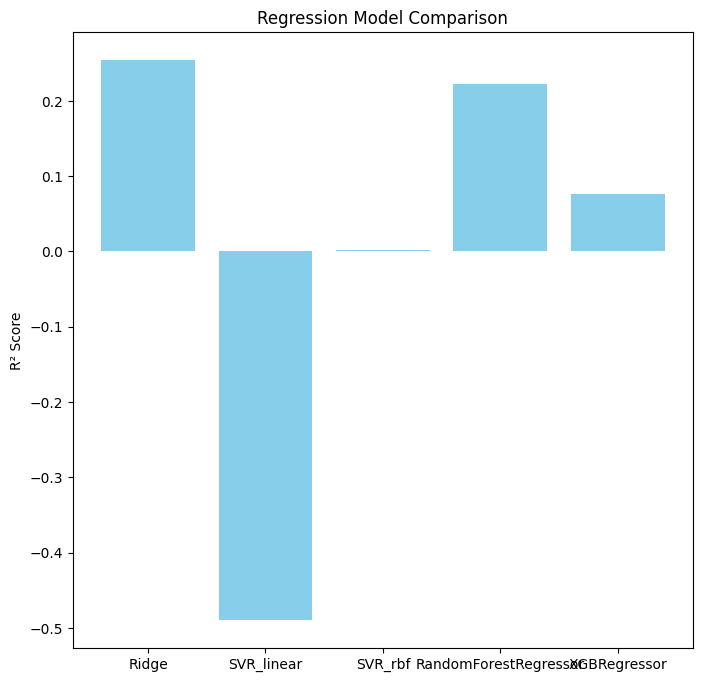

In [19]:
import matplotlib.pyplot as plt
model_names = list(regression_results.keys())
scores = list(regression_results.values())

plt.figure(figsize=(8,8))
plt.bar(model_names, scores, color='skyblue')
plt.ylabel("R² Score")
plt.title("Regression Model Comparison")
plt.savefig("regression_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

* Which model did the best?  
* How could you improve its results?  
* What metric does the `score()` method of a regression model return by default?

Since we've fitted several models and compared them using the default metric contained in the `score()` method (R² score or coefficient of determination), the next step is to **perform hyperparameter tuning** on the `RidgeRegression` model using `GridSearchCV`. This will help us find the best configuration before continuing with a deeper evaluation.

Once the best Ridge model is selected, we'll evaluate it using a few additional [regression metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics):

1. **R² (pronounced r-squared) or coefficient of determination** – Compares your model’s predictions to the mean of the targets. Values range from negative infinity (poor model) to 1 (perfect prediction).
2. **Mean absolute error (MAE)** – The average of the absolute differences between predictions and actual values. It gives an idea of how wrong the predictions were.
3. **Mean squared error (MSE)** – The average squared differences between predictions and actual values. Squaring the errors removes negatives and amplifies outliers.

Scikit-Learn provides built-in functions to calculate these metrics:
- [`mean_absolute_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)
- [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
- [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)


In [20]:
from sklearn.model_selection import GridSearchCV

# Define Ridge model with random_state
ridge = Ridge(random_state=42)

# Define hyperparameter grid
ridge_params = {"alpha": [0.1, 1.0, 10.0, 100.0]}

# Create GridSearchCV (no random_state here)
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_params, cv=5)

# Build pipeline
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", ridge_grid)
])

# Fit pipeline
ridge_pipeline.fit(car_X_train, car_y_train)

# Access best model and score
best_ridge_model = ridge_pipeline.named_steps["model"].best_estimator_
best_ridge_score = best_ridge_model.score(preprocessor.transform(car_X_test), car_y_test)

print(f"Best Ridge Model Score: {best_ridge_score:.4f}")


Best Ridge Model Score: 0.2562


In [21]:
# Import mean_absolute_error from sklearn's metrics module
###
from sklearn.metrics import mean_absolute_error
# Import mean_squared_error from sklearn's metrics module
###
from sklearn.metrics import mean_squared_error
# Import r2_score from sklearn's metrics module
###
from sklearn.metrics import r2_score

All the evaluation metrics we're concerned with compare a model's predictions with the ground truth labels. Knowing this, we'll have to make some predictions.

Let's create a `Pipeline` with the `preprocessor` and a `Ridge()` model, fit it on the car sales training data and then make predictions on the car sales test data.

In [22]:
# Create RidgeRegression Pipeline with preprocessor as the "preprocessor" and
# Ridge() as the "model".
ridge_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", best_ridge_model)])

# Fit the RidgeRegression Pipeline to the car sales training data
ridge_pipeline.fit(car_X_train, car_y_train)

# Make predictions on the car sales test data using the RidgeRegression Pipeline
car_y_preds = ridge_pipeline.predict(car_X_test)

# View the first 50 predictions
### 
car_y_preds[:50]

array([18506.76860424, 22140.28716467, 11150.36205346,  7349.74133129,
        8844.37938384, 10922.65841474, 15547.19868286, 14286.12695319,
       20354.71257144, 14496.79948457,  6608.51200028, 16930.93535134,
       11779.0000773 , 13651.01142503, 14315.34731749, 16418.67592869,
       15974.36640094, 10206.87498943, 11662.12031252, 11520.73741874,
       10585.71544716, 13447.26469456, 17867.47490036, 22666.16829313,
       12187.32682109, 14936.31389422, 18696.19479714, 14655.40632869,
       20732.73819364, 20120.2278214 , 18245.63479554, 22338.06275516,
       12522.11520855, 14545.14094215, 18288.77601128, 19665.40330091,
       12208.17124779, 12648.87381559, 18614.93789294, 11280.42075552,
       15557.97156665, 17352.67993295, 19239.73509766, 17492.45994682,
       15216.64196683, 13195.19794169, 12365.96332512,  8526.22021586,
       15404.98286463, 18704.0516711 ])

Nice! Now we've got some predictions, time to evaluate them. We'll find the mean squared error (MSE), mean absolute error (MAE) and R^2 score (coefficient of determination) of our model.

In [23]:
# EXAMPLE: Find the MSE by comparing the car sales test labels to the car sales predictions
mse = mean_squared_error(car_y_test, car_y_preds)
# Return the MSE
mse

49803041.72189363

In [24]:
# Find the MAE by comparing the car sales test labels to the car sales predictions
###
mae = mean_absolute_error(car_y_test, car_y_preds)
# Return the MAE
###
mae

5709.844797110872

In [25]:
# Find the R2 score by comparing the car sales test labels to the car sales predictions
###
r2 = r2_score(car_y_test, car_y_preds)
# Return the r2 score
###
r2

0.25622356556846215

Boom! Our model could potentially do with some hyperparameter tuning (this would be a great extension). And we could probably do with finding some more data on our problem, 1000 rows doesn't seem to be sufficient.

* How would you export the trained regression model?

In [26]:
import joblib
joblib.dump(ridge_pipeline, "ridge_model.joblib")

['ridge_model.joblib']